<a href="https://colab.research.google.com/github/SampadSikder/Nonnegative-Matrix-Factorization-Experimentation/blob/main/AT%26T_multiple_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Equations from https://proceedings.neurips.cc/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf
Edges after nmf in basis matrix: http://www.cs.cmu.edu/~./changbo/publications/IJPRAI05.pdf

In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans
import numpy
import matplotlib.pyplot as mtp

In [ ]:
from google.colab import drive
drive.mount('/content/Drive')

KeyboardInterrupt: ignored

# Code Library

In [2]:
import time

def extractFrameFromImage(filePath, imageLimit, frame_rate):
  vidcap = cv2.VideoCapture(filePath)
  success,image = vidcap.read()
  count = 0
  #define framerate
  frame_rate = 10
  prev = 0
  frame=0
  while success:
    time_elapsed = time.time() - prev
    success,image = vidcap.read()  
    if time_elapsed > 1./frame_rate:
      prev = time.time()
      cv2.imwrite("%d.jpg" % count, image)     # save frame as JPEG file      
      #print('Read a new frame: ', success)
      count=count+1
      frame += frame_rate # i.e. at 30 fps, this advances one second
      vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame)
    if count>=imageLimit:
      break
  vidcap.release()
  cv2.destroyAllWindows()

  

In [3]:
def checkCrop():
  img=cv2.imread('/content/9.jpg')
  img=img[350:600,400:600]
  cv2_imshow(img)

In [33]:
import os
def countWidthandHeight():
  #img=cv2.imread('/content/9.jpg')
  img=cv2.imread('/content/9.pgm')
  image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #resize
  
  width = int(image.shape[1])
  
  height = int(image.shape[0])
  
  print(width, height)

  


  count=0

  for image_name in os.listdir('/content'):
    extension = os.path.splitext(image_name)[1][1:]
    if extension=='pgm':
      count=count+1

  return width, height, count

In [5]:
def singleImage(path):
  img=cv2.imread(path)
  
  image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #resize
  
  width = int(image.shape[1])
  
  height = int(image.shape[0])


  dim = (width, height)
  print(width, height)
  #resizing image
  resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

  return image, width, height

In [6]:
def multiplyImage():
  img=cv2.imread('/content/9.jpg')
  image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #resize
  imageT=np.transpose(image)
  result=np.matmul(image,imageT)

  cv2_imshow(result)


In [28]:


def convertAllImageToMatrix(width, height, x): # x = number of images
  
 

  y = width*height 

  m = np.zeros(shape=(x, int(y)))
  print(m.shape)
  itr = 0
  name_list = []
  for image_name in os.listdir('/content'):
    extension = os.path.splitext(image_name)[1][1:]
    #if extension=='jpg':
    if extension=='pgm':
      image_path='/content/'+image_name
      image = cv2.imread(image_path)
      #####flip image
      #image=cv2.flip(image,0)
      #crop image
      #img=image[350:600,400:600]
      #grayscale	
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      #resize
      dim = (width, height)
      print(width, height)
      #resizing image
      resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
      #rows,cols = resized.shape # gives dimensions for RGB array
      
      rows,cols=resized.shape#normal shape
      img_size = rows*cols
      img_1D_vector = resized.reshape(img_size)
      
      #print(img_1D_vector)
      #np.append(m, img_1D_vector,axis=0)
      m[itr]=img_1D_vector
      itr=itr+1
      name_list.append(image_name)
      print(itr)
      
  return m, name_list, itr

In [8]:
def normalizeM(m):
  sum=0
  row, col=m.shape
  for i in range(0,row):
    for j in range(0,col):
      sum+=m[i][j]
  mean=sum/row*col 

  m=m/mean

  return m, mean

In [9]:
def normalizeMin(m):
  min=99999999999999
  row, col=m.shape
  for i in range(0,row):
    for j in range(0,col):
      if m[i,j]<min:
        min=m[i,j]
  m=m/min
  return m, min

In [10]:
def normalizeMax(m):
  max=-1
  row, col=m.shape
  for i in range(0,row):
    for j in range(0,col):
      if m[i,j]>max:
        max=m[i,j]
  m=m/max
  return m, max

In [11]:
def updateW(x,w,h):
  #XVT
  ht=np.transpose(h)
  numerator=np.matmul(x,ht)
  #UVVT
  den1=np.matmul(w,h)
  denominator=np.matmul(den1,ht)

  #return
  print('u')
  secondPart=np.divide(numerator,denominator)
  return np.multiply(w,secondPart)

In [12]:
def updateH(x,w,h):
  #UT*X
  wt=np.transpose(w)
  numerator=np.matmul(wt,x)
  #UTUV
  den1=np.matmul(w,h)
  denominator=np.matmul(wt,den1)
  
  #update return
  print('v')
  secondPart=np.divide(numerator,denominator)
  return np.multiply(h,secondPart)

In [13]:
def performNMF(x, featureNo, imageCount, EPSILON=1e-9):
  w=abs(np.random.normal(3,2.5,size=(imageCount,featureNo)))
  h=abs(np.random.normal(3,2.5,size=(featureNo, x.shape[1])))

  print("Shape of W: "+str(w.shape))
  print("Shape of H: "+str(h.shape))

  itr=0
  cost=np.linalg.norm(x-np.matmul(w,h))
  while cost>EPSILON:
    if itr%2==0:
      h=updateH(x,w,h)
      #h*=6
    else:
      w=updateW(x,w,h)
      #w/=4
    wh=np.matmul(w,h)
    print(w,h)
    cost=np.linalg.norm(x-wh)
    print(cost)
    if itr>=100:
      break
    itr=itr+1
  return w,h

In [14]:
def getImageListFromM(x_new):
  #print(height,width)
  images = []
  for row in x_new:
    img_data = []
    for i in range(height):
      img_row = []
      for j in range(width):
        img_row.append(row[i*width + j])
      img_data.append(img_row)
    images.append(img_data)
  return images

In [15]:
def convertMatrixToImage(x,mean):
  x_new=np.zeros((x.shape[0],x.shape[1]), dtype=int)
  for i in range(x.shape[0]):
    for j in range(x.shape[1]):
      x_new[i][j]=x[i,j]*mean
      x_new[i][j]=math.ceil(x_new[i][j])
  print(x_new)
  return x_new

### Testing Code

In [16]:
from google.colab.patches import cv2_imshow


In [17]:
def compareAndTest(m, w, h, mean):
  x_new=np.matmul(w,h)
  x_new=np.ceil(x_new*mean)
  #x_new=np.transpose(x_new)

  resulting_images = getImageListFromM(x_new)
  original_images = getImageListFromM(np.ceil(m*mean))

  for index in range(m.shape[0]):
    print("-------------------------------Number of image: "+str(index))

    img=np.array(resulting_images[index])
    cv2_imshow(img)
    print("Image after NMF:")

    img=np.array(original_images[index])
    cv2_imshow(img)
    print("Image Before NMF:")


In [18]:
def variance(m): # m = matrix of all images
  return np.var(m)

In [19]:
def __grouper(labels, original_images, resulting_images):
    groups = []
    for current_label in set(labels):
      cluster = []
      for index,label in enumerate(labels):
        if label == current_label:
          node = [label, original_images[index], resulting_images[index]]
          cluster.append(node)
      groups.append(cluster)
    return groups

In [20]:
def compareAndTestWithKNN(m, w, h, mean, n_clusters):
  x_new=np.matmul(w,h)
  x_new=np.ceil(x_new*mean)
  #x_new=np.transpose(x_new)

  kmeans = KMeans(n_clusters, random_state=0)
  kmeans.fit(w)

  resulting_images = getImageListFromM(x_new)
  original_images = getImageListFromM(np.ceil(m*mean))
  
  clusters = __grouper(kmeans.labels_, original_images, resulting_images)

  for cluster in clusters:
    print("----------------Labels------------------------")
    for index, node in enumerate(cluster):
      print("-------------------------------Number of image: "+str(index)+"-----------Cluster="+str(node[0])+".")
      img=np.array(node[1])
      cv2_imshow(img)
  
  return kmeans

In [21]:
def scatterPlot(kmeans,F):
  y_predict= kmeans.fit_predict(F)  
  mtp.scatter(F[y_predict == 0, 0], F[y_predict == 0, 1], s = 10, c = 'blue', label = 'Cluster 1') #for first cluster  
  mtp.scatter(F[y_predict == 1, 0], F[y_predict == 1, 1], s = 10, c = 'green', label = 'Cluster 2') #for second cluster  
  mtp.scatter(F[y_predict== 2, 0], F[y_predict == 2, 1], s = 10, c = 'red', label = 'Cluster 3') #for third cluster  
  mtp.scatter(F[y_predict == 3, 0], F[y_predict == 3, 1], s = 10, c = 'cyan', label = 'Cluster 4') #for fourth cluster  
  mtp.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 30, c = 'yellow', label = 'Centroid')   
  mtp.title('Clusters')  

  mtp.legend()  
  mtp.show() 

# Experimentation Area

In [ ]:
imageLimit = 100
frame_rate=5
extractFrameFromImage('/content/Drive/MyDrive/Colab Notebooks/Dataset/ClothStackDetection.mp4', imageLimit, frame_rate)

In [ ]:
!ls

In [ ]:
width, height, imageCount=countWidthandHeight()

In [ ]:
print(imageCount)

In [ ]:
m, imageNameList, imageCount = convertAllImageToMatrix(width, height, imageCount)


In [ ]:
m.shape

In [ ]:
m

In [ ]:
m, mean = normalizeM(m)

In [ ]:
w,h=performNMF(m, 10, imageCount)

# from sklearn.decomposition import NMF
# nmf_model = NMF(10,max_iter=100)
# w = nmf_model.fit_transform(m)
# h=nmf_model.components_


In [ ]:
compareAndTest(m,w,h, mean)

In [ ]:
x_new=np.matmul(w,h)
x_new=np.ceil(x_new*mean)
x_new=np.transpose(x_new)

print("Original Image Set Variance: "+str(variance(np.ceil(np.transpose(m)*mean))))
print("NMF Generated Image Set Variance: "+str(variance(x_new)))

In [ ]:
w.shape

# Clustering

In [ ]:
kmeans=compareAndTestWithKNN(m,w,h, mean, 3)

In [ ]:
scatterPlot(kmeans,w)

#Visualization


In [ ]:
m,width,height=singleImage('/content/8.jpg')
print(width,height)

#multiplyImage()

In [ ]:
#m,mean=normalizeM(m)
print(m)
w,h=performNMF(m, 10, height)
print(m)
'''
from sklearn.decomposition import NMF
nmf_model = NMF(100,max_iter=100)
w = nmf_model.fit_transform(m)
h=nmf_model.components_
'''

In [ ]:
import math
m=m
cv2_imshow(m)
#cv2_imshow(convertMatrixToImage(np.matmul(w,h),mean))
cv2_imshow(np.matmul(w,h))

In [ ]:
#cv2_imshow(convertMatrixToImage(w,mean))
cv2_imshow(np.ceil(w))
print(np.ceil(w))

In [ ]:
#cv2_imshow(convertMatrixToImage(h,mean))
print(w.shape)
col=np.transpose(w)
temp=col[0].reshape(11,23)
print(temp)
cv2_imshow(temp)

In [ ]:
cv2_imshow(np.matmul(w,h))

#Temp

In [ ]:
!find content/Face-recognition/Datasets/att_faces/Training -type f -print0 | xargs -0 mv -t /content

In [104]:
!rm content/Face-recognition -r 

rm: cannot remove 'content/Face-recognition': No such file or directory


In [26]:
!git clone https://github.com/mohamed-elsayed-mohamed/Face-Recognition.git

fatal: destination path 'Face-Recognition' already exists and is not an empty directory.


In [ ]:
print(m)
w,h=performNMF(m, 10, height)
print(m)

Streaming output truncated to the last 5000 lines.
 [0.34597828 3.14426643 0.72743952 ... 4.74557699 3.20373488 0.96155385]
 [1.75322273 5.125309   1.18489538 ... 3.51585258 3.40181553 0.28915337]
 [1.34406938 7.03712118 2.13409084 ... 3.84289036 2.0352155  0.65373096]] [[3.95163503e+00 4.38003081e+00 4.29259246e+00 2.68132097e+00
  6.46318444e+00 3.33646284e+00 4.48170713e+00 2.92770894e+00
  1.18181132e+00 5.80247070e+00 5.12738289e+00 3.53634865e+00
  2.90915977e+00 2.05763446e+00 4.53130457e+00 5.27101556e+00
  2.69817266e+00 6.85697769e+00 5.61927734e+00 2.84051235e+00
  5.59187765e+00 5.78848011e+00 5.85456947e+00 7.05601216e+00
  5.10708456e+00 5.50453556e+00 1.99666136e+00 1.98242411e+00
  4.86224359e+00 6.03304256e+00 7.07036262e+00 9.65557508e-01
  4.09676731e+00 4.80486991e+00 7.06333855e+00 3.78731615e+00
  4.41958734e+00 1.69809046e-01 3.57851256e+00 2.83328336e+00
  1.98696564e+00 5.51355479e+00 7.22754145e+00 3.27348329e+00
  3.39950056e+00 2.13421652e-01 2.57483302e-02 

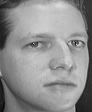

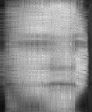

In [ ]:
import math
m=m
cv2_imshow(m)
#cv2_imshow(convertMatrixToImage(np.matmul(w,h),mean))
cv2_imshow(np.matmul(w,h))

In [ ]:
m,mean=normalizeM(m)
w,h=performNMF(m, 10, height)
print(m)

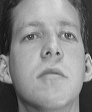

[[41 42 44 ... 49 53 53]
 [42 40 42 ... 47 52 54]
 [41 42 42 ... 48 52 51]
 ...
 [32 32 28 ... 40 39 40]
 [36 35 28 ... 41 42 41]
 [36 35 29 ... 42 42 42]]


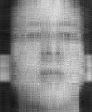

In [ ]:
import math
cv2_imshow(m*mean)
cv2_imshow(convertMatrixToImage(np.matmul(w,h),mean))

In [ ]:
m,minn=normalizeMin(m)
w,h=performNMF(m, 10, height)
print(m)

Streaming output truncated to the last 5000 lines.
 [3.1471087  0.39865392 4.21717388 ... 0.8452539  4.98663337 2.75973568]
 [3.08665064 0.84225506 3.03347438 ... 0.42248857 6.30754184 1.81093037]
 [3.11327918 0.84135452 2.35204505 ... 0.28627643 5.85251574 2.81659002]] [[2.49751474e-03 3.60008048e-03 2.84545559e-03 1.72120173e-04
  2.51456426e-03 4.26022040e-03 8.90829195e-03 9.16158620e-03
  1.20383434e-02 2.85895739e-02 9.94402313e-03 8.76459149e-03
  4.64440170e-02 6.59925175e-02 1.09452803e-02 3.84654621e-02
  1.48871979e-02 1.47664275e-01 1.93663253e-01 2.70539532e-01
  1.59208963e-01 2.87615053e-01 1.68480432e-01 2.64086280e-01
  1.79676127e-01 2.94152429e-01 2.90374118e-01 2.01434982e-01
  3.04940307e-01 2.57100827e-01 2.91604042e-01 2.27110707e-01
  2.79789109e-01 1.71283328e-01 2.57273509e-01 4.96521806e-01
  3.00629522e-01 3.61388416e-01 5.37670734e-01 4.72432687e-01
  4.88256125e-01 4.93637776e-01 8.18728995e-01 5.58368465e-01
  5.61664985e-01 3.56407434e-01 6.11955094e-01 

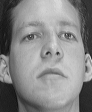

[[30 29 33 ... 42 40 42]
 [30 30 34 ... 42 40 31]
 [33 35 37 ... 45 42 43]
 ...
 [27 26 24 ... 40 33 44]
 [29 30 27 ... 42 36 44]
 [28 30 27 ... 41 35 45]]


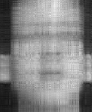

In [ ]:
import math
cv2_imshow(m*minn)
cv2_imshow(convertMatrixToImage(np.matmul(w,h),minn))

In [ ]:
m,minn=normalizeMax(m)
w,h=performNMF(m, 10, height)
print(m)

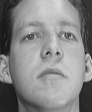

[[26 26 24 ... 32 31 34]
 [32 31 28 ... 34 33 35]
 [25 24 23 ... 34 29 37]
 ...
 [34 35 33 ... 45 40 42]
 [33 33 31 ... 41 40 41]
 [38 39 37 ... 44 43 48]]


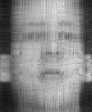

In [ ]:
import math
cv2_imshow(m*minn)
cv2_imshow(convertMatrixToImage(np.matmul(w,h),minn))

#Test on multiple images

In [27]:
import shutil
counter = 1
source = "/content/Face-Recognition/Datasets/att_faces/Training"
destination = "/content/"

# code to move the files from sub-folder to main folder.
for root, dirs, files in os.walk(source):
    for file in files:
        # Get the full path of the file
        file_path = os.path.join(root, file)
        
        file_extension = os.path.splitext(file)[1]
        
        # Create the new file name
        new_file_name = str(counter) + file_extension
        
        # Move the file to the destination and rename it
        shutil.move(file_path, os.path.join(destination, new_file_name))
        
        # Increment the counter
        counter += 1
print("Files Moved")

Files Moved


In [38]:
width, height, imageCount=countWidthandHeight()

92 112


In [39]:
m, imageNameList, imageCount = convertAllImageToMatrix(width, height, imageCount)

(351, 10304)
92 112
1
92 112
2
92 112
3
92 112
4
92 112
5
92 112
6
92 112
7
92 112
8
92 112
9
92 112
10
92 112
11
92 112
12
92 112
13
92 112
14
92 112
15
92 112
16
92 112
17
92 112
18
92 112
19
92 112
20
92 112
21
92 112
22
92 112
23
92 112
24
92 112
25
92 112
26
92 112
27
92 112
28
92 112
29
92 112
30
92 112
31
92 112
32
92 112
33
92 112
34
92 112
35
92 112
36
92 112
37
92 112
38
92 112
39
92 112
40
92 112
41
92 112
42
92 112
43
92 112
44
92 112
45
92 112
46
92 112
47
92 112
48
92 112
49
92 112
50
92 112
51
92 112
52
92 112
53
92 112
54
92 112
55
92 112
56
92 112
57
92 112
58
92 112
59
92 112
60
92 112
61
92 112
62
92 112
63
92 112
64
92 112
65
92 112
66
92 112
67
92 112
68
92 112
69
92 112
70
92 112
71
92 112
72
92 112
73
92 112
74
92 112
75
92 112
76
92 112
77
92 112
78
92 112
79
92 112
80
92 112
81
92 112
82
92 112
83
92 112
84
92 112
85
92 112
86
92 112
87
92 112
88
92 112
89
92 112
90
92 112
91
92 112
92
92 112
93
92 112
94
92 112
95
92 112
96
92 112
97
92 112
98
92 112
99
92 112

In [ ]:
#m, mean = normalizeM(m)

In [40]:
#w,h=performNMF(m, 10, imageCount)

from sklearn.decomposition import NMF
nmf_model = NMF(10,max_iter=100)
w = nmf_model.fit_transform(m)
h=nmf_model.components_


-------------------------------Number of image: 0


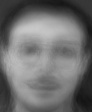

Image after NMF:


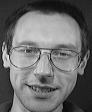

Image Before NMF:
-------------------------------Number of image: 1


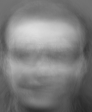

Image after NMF:


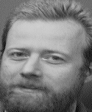

Image Before NMF:
-------------------------------Number of image: 2


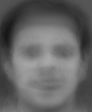

Image after NMF:


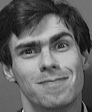

Image Before NMF:
-------------------------------Number of image: 3


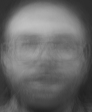

Image after NMF:


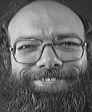

Image Before NMF:
-------------------------------Number of image: 4


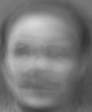

Image after NMF:


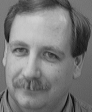

Image Before NMF:
-------------------------------Number of image: 5


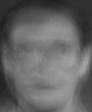

Image after NMF:


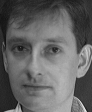

Image Before NMF:
-------------------------------Number of image: 6


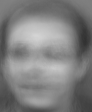

Image after NMF:


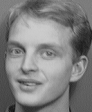

Image Before NMF:
-------------------------------Number of image: 7


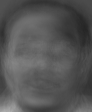

Image after NMF:


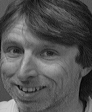

Image Before NMF:
-------------------------------Number of image: 8


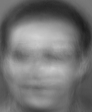

Image after NMF:


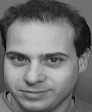

Image Before NMF:
-------------------------------Number of image: 9


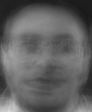

Image after NMF:


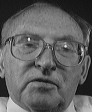

Image Before NMF:
-------------------------------Number of image: 10


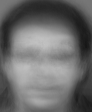

Image after NMF:


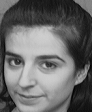

Image Before NMF:
-------------------------------Number of image: 11


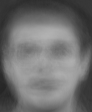

Image after NMF:


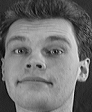

Image Before NMF:
-------------------------------Number of image: 12


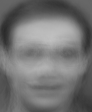

Image after NMF:


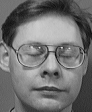

Image Before NMF:
-------------------------------Number of image: 13


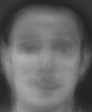

Image after NMF:


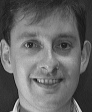

Image Before NMF:
-------------------------------Number of image: 14


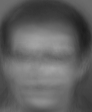

Image after NMF:


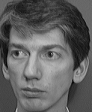

Image Before NMF:
-------------------------------Number of image: 15


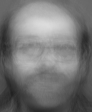

Image after NMF:


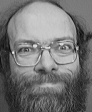

Image Before NMF:
-------------------------------Number of image: 16


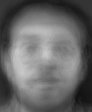

Image after NMF:


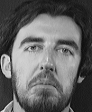

Image Before NMF:
-------------------------------Number of image: 17


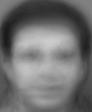

Image after NMF:


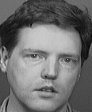

Image Before NMF:
-------------------------------Number of image: 18


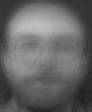

Image after NMF:


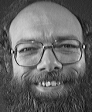

Image Before NMF:
-------------------------------Number of image: 19


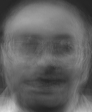

Image after NMF:


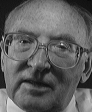

Image Before NMF:
-------------------------------Number of image: 20


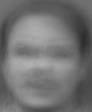

Image after NMF:


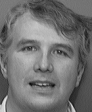

Image Before NMF:
-------------------------------Number of image: 21


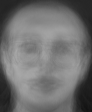

Image after NMF:


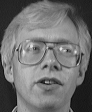

Image Before NMF:
-------------------------------Number of image: 22


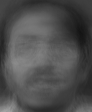

Image after NMF:


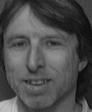

Image Before NMF:
-------------------------------Number of image: 23


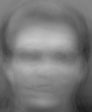

Image after NMF:


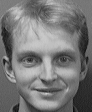

Image Before NMF:
-------------------------------Number of image: 24


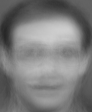

Image after NMF:


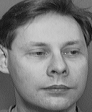

Image Before NMF:
-------------------------------Number of image: 25


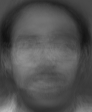

Image after NMF:


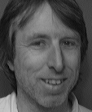

Image Before NMF:
-------------------------------Number of image: 26


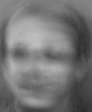

Image after NMF:


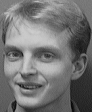

Image Before NMF:
-------------------------------Number of image: 27


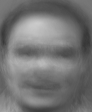

Image after NMF:


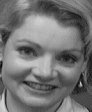

Image Before NMF:
-------------------------------Number of image: 28


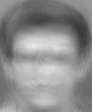

Image after NMF:


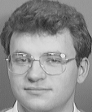

Image Before NMF:
-------------------------------Number of image: 29


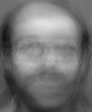

Image after NMF:


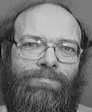

Image Before NMF:
-------------------------------Number of image: 30


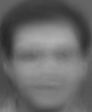

Image after NMF:


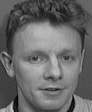

Image Before NMF:
-------------------------------Number of image: 31


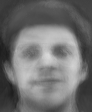

Image after NMF:


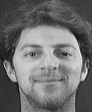

Image Before NMF:
-------------------------------Number of image: 32


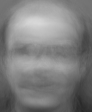

Image after NMF:


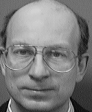

Image Before NMF:
-------------------------------Number of image: 33


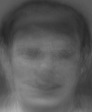

Image after NMF:


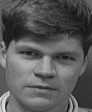

Image Before NMF:
-------------------------------Number of image: 34


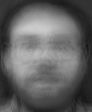

Image after NMF:


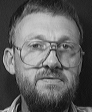

Image Before NMF:
-------------------------------Number of image: 35


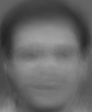

Image after NMF:


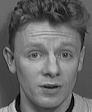

Image Before NMF:
-------------------------------Number of image: 36


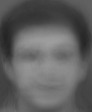

Image after NMF:


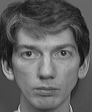

Image Before NMF:
-------------------------------Number of image: 37


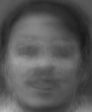

Image after NMF:


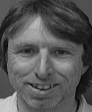

Image Before NMF:
-------------------------------Number of image: 38


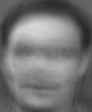

Image after NMF:


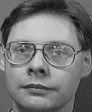

Image Before NMF:
-------------------------------Number of image: 39


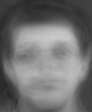

Image after NMF:


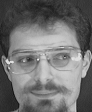

Image Before NMF:
-------------------------------Number of image: 40


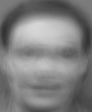

Image after NMF:


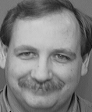

Image Before NMF:
-------------------------------Number of image: 41


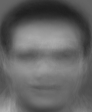

Image after NMF:


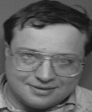

Image Before NMF:
-------------------------------Number of image: 42


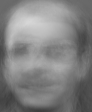

Image after NMF:


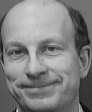

Image Before NMF:
-------------------------------Number of image: 43


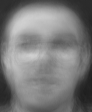

Image after NMF:


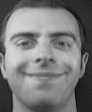

Image Before NMF:
-------------------------------Number of image: 44


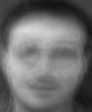

Image after NMF:


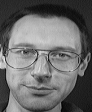

Image Before NMF:
-------------------------------Number of image: 45


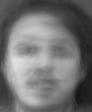

Image after NMF:


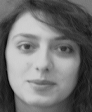

Image Before NMF:
-------------------------------Number of image: 46


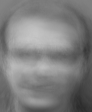

Image after NMF:


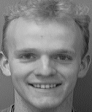

Image Before NMF:
-------------------------------Number of image: 47


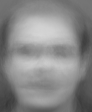

Image after NMF:


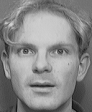

Image Before NMF:
-------------------------------Number of image: 48


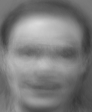

Image after NMF:


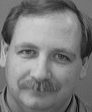

Image Before NMF:
-------------------------------Number of image: 49


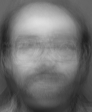

Image after NMF:


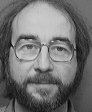

Image Before NMF:
-------------------------------Number of image: 50


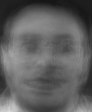

Image after NMF:


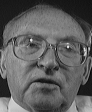

Image Before NMF:
-------------------------------Number of image: 51


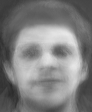

Image after NMF:


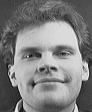

Image Before NMF:
-------------------------------Number of image: 52


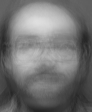

Image after NMF:


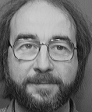

Image Before NMF:
-------------------------------Number of image: 53


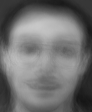

Image after NMF:


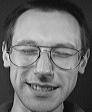

Image Before NMF:
-------------------------------Number of image: 54


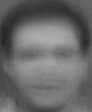

Image after NMF:


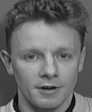

Image Before NMF:
-------------------------------Number of image: 55


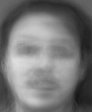

Image after NMF:


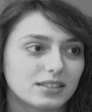

Image Before NMF:
-------------------------------Number of image: 56


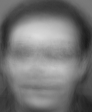

Image after NMF:


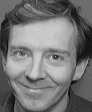

Image Before NMF:
-------------------------------Number of image: 57


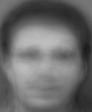

Image after NMF:


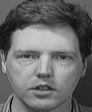

Image Before NMF:
-------------------------------Number of image: 58


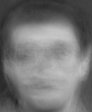

Image after NMF:


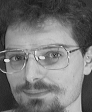

Image Before NMF:
-------------------------------Number of image: 59


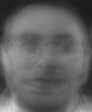

Image after NMF:


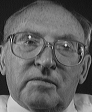

Image Before NMF:
-------------------------------Number of image: 60


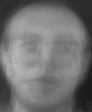

Image after NMF:


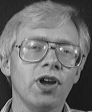

Image Before NMF:
-------------------------------Number of image: 61


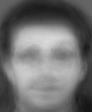

Image after NMF:


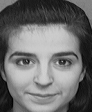

Image Before NMF:
-------------------------------Number of image: 62


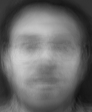

Image after NMF:


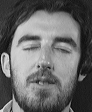

Image Before NMF:
-------------------------------Number of image: 63


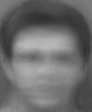

Image after NMF:


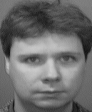

Image Before NMF:
-------------------------------Number of image: 64


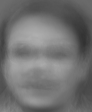

Image after NMF:


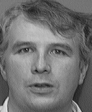

Image Before NMF:
-------------------------------Number of image: 65


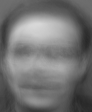

Image after NMF:


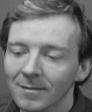

Image Before NMF:
-------------------------------Number of image: 66


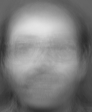

Image after NMF:


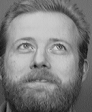

Image Before NMF:
-------------------------------Number of image: 67


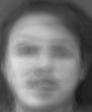

Image after NMF:


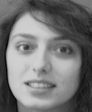

Image Before NMF:
-------------------------------Number of image: 68


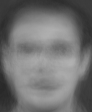

Image after NMF:


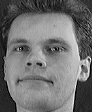

Image Before NMF:
-------------------------------Number of image: 69


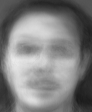

Image after NMF:


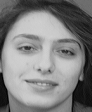

Image Before NMF:
-------------------------------Number of image: 70


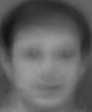

Image after NMF:


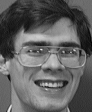

Image Before NMF:
-------------------------------Number of image: 71


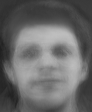

Image after NMF:


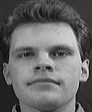

Image Before NMF:
-------------------------------Number of image: 72


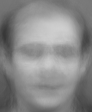

Image after NMF:


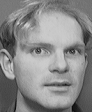

Image Before NMF:
-------------------------------Number of image: 73


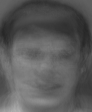

Image after NMF:


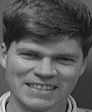

Image Before NMF:
-------------------------------Number of image: 74


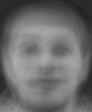

Image after NMF:


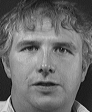

Image Before NMF:
-------------------------------Number of image: 75


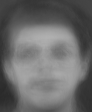

Image after NMF:


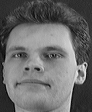

Image Before NMF:
-------------------------------Number of image: 76


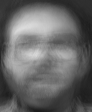

Image after NMF:


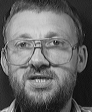

Image Before NMF:
-------------------------------Number of image: 77


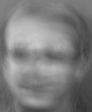

Image after NMF:


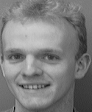

Image Before NMF:
-------------------------------Number of image: 78


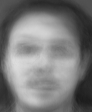

Image after NMF:


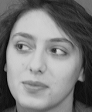

Image Before NMF:
-------------------------------Number of image: 79


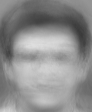

Image after NMF:


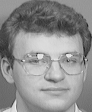

Image Before NMF:
-------------------------------Number of image: 80


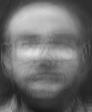

Image after NMF:


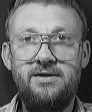

Image Before NMF:
-------------------------------Number of image: 81


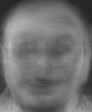

Image after NMF:


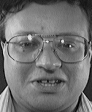

Image Before NMF:
-------------------------------Number of image: 82


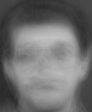

Image after NMF:


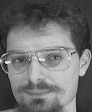

Image Before NMF:
-------------------------------Number of image: 83


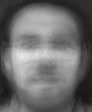

Image after NMF:


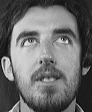

Image Before NMF:
-------------------------------Number of image: 84


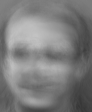

Image after NMF:


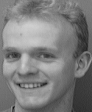

Image Before NMF:
-------------------------------Number of image: 85


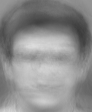

Image after NMF:


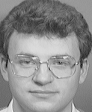

Image Before NMF:
-------------------------------Number of image: 86


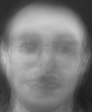

Image after NMF:


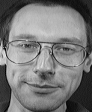

Image Before NMF:
-------------------------------Number of image: 87


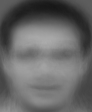

Image after NMF:


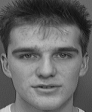

Image Before NMF:
-------------------------------Number of image: 88


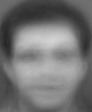

Image after NMF:


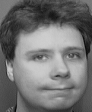

Image Before NMF:
-------------------------------Number of image: 89


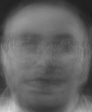

Image after NMF:


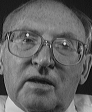

Image Before NMF:
-------------------------------Number of image: 90


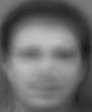

Image after NMF:


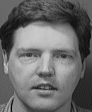

Image Before NMF:
-------------------------------Number of image: 91


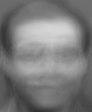

Image after NMF:


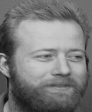

Image Before NMF:
-------------------------------Number of image: 92


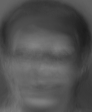

Image after NMF:


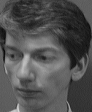

Image Before NMF:
-------------------------------Number of image: 93


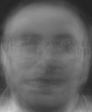

Image after NMF:


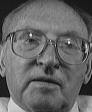

Image Before NMF:
-------------------------------Number of image: 94


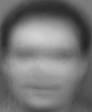

Image after NMF:


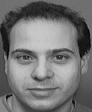

Image Before NMF:
-------------------------------Number of image: 95


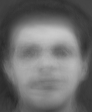

Image after NMF:


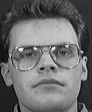

Image Before NMF:
-------------------------------Number of image: 96


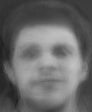

Image after NMF:


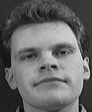

Image Before NMF:
-------------------------------Number of image: 97


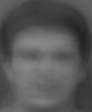

Image after NMF:


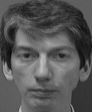

Image Before NMF:
-------------------------------Number of image: 98


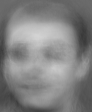

Image after NMF:


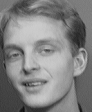

Image Before NMF:
-------------------------------Number of image: 99


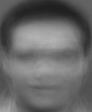

Image after NMF:


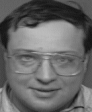

Image Before NMF:
-------------------------------Number of image: 100


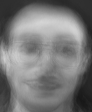

Image after NMF:


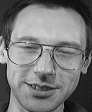

Image Before NMF:
-------------------------------Number of image: 101


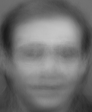

Image after NMF:


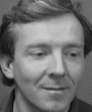

Image Before NMF:
-------------------------------Number of image: 102


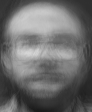

Image after NMF:


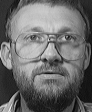

Image Before NMF:
-------------------------------Number of image: 103


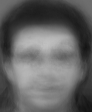

Image after NMF:


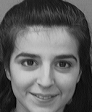

Image Before NMF:
-------------------------------Number of image: 104


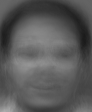

Image after NMF:


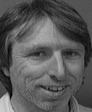

Image Before NMF:
-------------------------------Number of image: 105


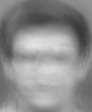

Image after NMF:


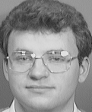

Image Before NMF:
-------------------------------Number of image: 106


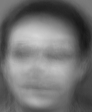

Image after NMF:


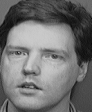

Image Before NMF:
-------------------------------Number of image: 107


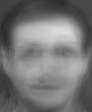

Image after NMF:


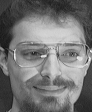

Image Before NMF:
-------------------------------Number of image: 108


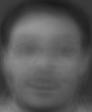

Image after NMF:


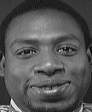

Image Before NMF:
-------------------------------Number of image: 109


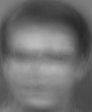

Image after NMF:


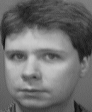

Image Before NMF:
-------------------------------Number of image: 110


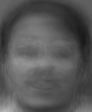

Image after NMF:


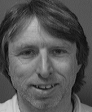

Image Before NMF:
-------------------------------Number of image: 111


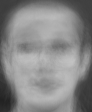

Image after NMF:


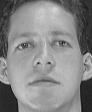

Image Before NMF:
-------------------------------Number of image: 112


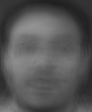

Image after NMF:


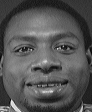

Image Before NMF:
-------------------------------Number of image: 113


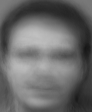

Image after NMF:


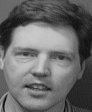

Image Before NMF:
-------------------------------Number of image: 114


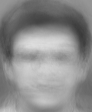

Image after NMF:


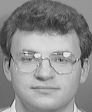

Image Before NMF:
-------------------------------Number of image: 115


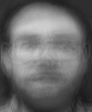

Image after NMF:


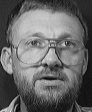

Image Before NMF:
-------------------------------Number of image: 116


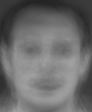

Image after NMF:


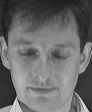

Image Before NMF:
-------------------------------Number of image: 117


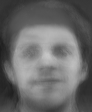

Image after NMF:


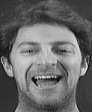

Image Before NMF:
-------------------------------Number of image: 118


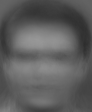

Image after NMF:


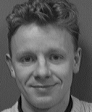

Image Before NMF:
-------------------------------Number of image: 119


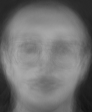

Image after NMF:


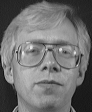

Image Before NMF:
-------------------------------Number of image: 120


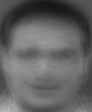

Image after NMF:


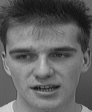

Image Before NMF:
-------------------------------Number of image: 121


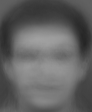

Image after NMF:


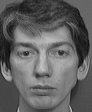

Image Before NMF:
-------------------------------Number of image: 122


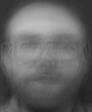

Image after NMF:


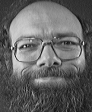

Image Before NMF:
-------------------------------Number of image: 123


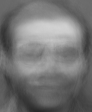

Image after NMF:


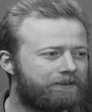

Image Before NMF:
-------------------------------Number of image: 124


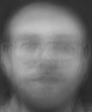

Image after NMF:


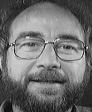

Image Before NMF:
-------------------------------Number of image: 125


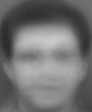

Image after NMF:


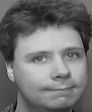

Image Before NMF:
-------------------------------Number of image: 126


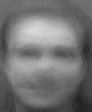

Image after NMF:


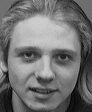

Image Before NMF:
-------------------------------Number of image: 127


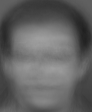

Image after NMF:


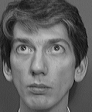

Image Before NMF:
-------------------------------Number of image: 128


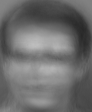

Image after NMF:


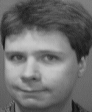

Image Before NMF:
-------------------------------Number of image: 129


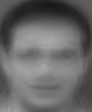

Image after NMF:


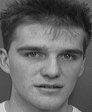

Image Before NMF:
-------------------------------Number of image: 130


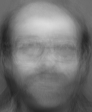

Image after NMF:


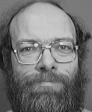

Image Before NMF:
-------------------------------Number of image: 131


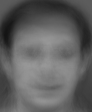

Image after NMF:


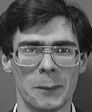

Image Before NMF:
-------------------------------Number of image: 132


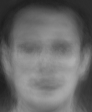

Image after NMF:


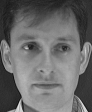

Image Before NMF:
-------------------------------Number of image: 133


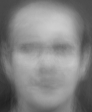

Image after NMF:


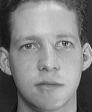

Image Before NMF:
-------------------------------Number of image: 134


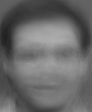

Image after NMF:


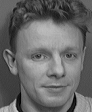

Image Before NMF:
-------------------------------Number of image: 135


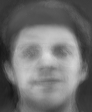

Image after NMF:


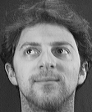

Image Before NMF:
-------------------------------Number of image: 136


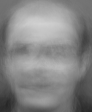

Image after NMF:


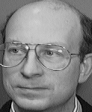

Image Before NMF:
-------------------------------Number of image: 137


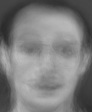

Image after NMF:


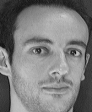

Image Before NMF:
-------------------------------Number of image: 138


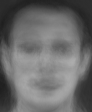

Image after NMF:


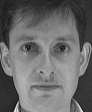

Image Before NMF:
-------------------------------Number of image: 139


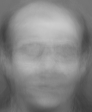

Image after NMF:


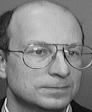

Image Before NMF:
-------------------------------Number of image: 140


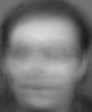

Image after NMF:


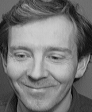

Image Before NMF:
-------------------------------Number of image: 141


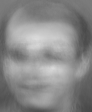

Image after NMF:


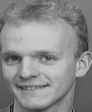

Image Before NMF:
-------------------------------Number of image: 142


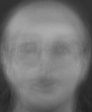

Image after NMF:


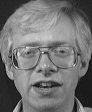

Image Before NMF:
-------------------------------Number of image: 143


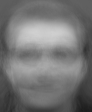

Image after NMF:


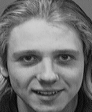

Image Before NMF:
-------------------------------Number of image: 144


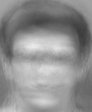

Image after NMF:


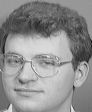

Image Before NMF:
-------------------------------Number of image: 145


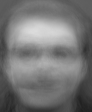

Image after NMF:


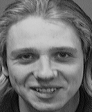

Image Before NMF:
-------------------------------Number of image: 146


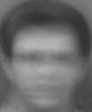

Image after NMF:


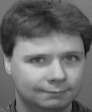

Image Before NMF:
-------------------------------Number of image: 147


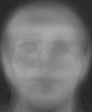

Image after NMF:


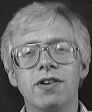

Image Before NMF:
-------------------------------Number of image: 148


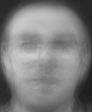

Image after NMF:


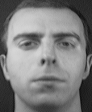

Image Before NMF:
-------------------------------Number of image: 149


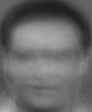

Image after NMF:


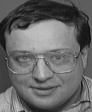

Image Before NMF:
-------------------------------Number of image: 150


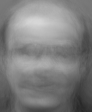

Image after NMF:


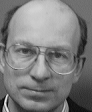

Image Before NMF:
-------------------------------Number of image: 151


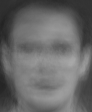

Image after NMF:


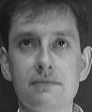

Image Before NMF:
-------------------------------Number of image: 152


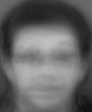

Image after NMF:


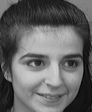

Image Before NMF:
-------------------------------Number of image: 153


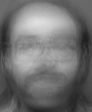

Image after NMF:


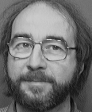

Image Before NMF:
-------------------------------Number of image: 154


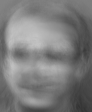

Image after NMF:


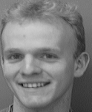

Image Before NMF:
-------------------------------Number of image: 155


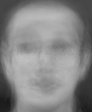

Image after NMF:


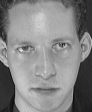

Image Before NMF:
-------------------------------Number of image: 156


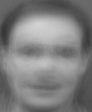

Image after NMF:


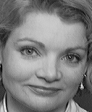

Image Before NMF:
-------------------------------Number of image: 157


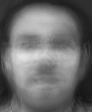

Image after NMF:


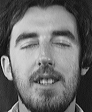

Image Before NMF:
-------------------------------Number of image: 158


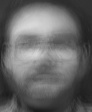

Image after NMF:


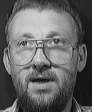

Image Before NMF:
-------------------------------Number of image: 159


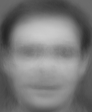

Image after NMF:


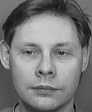

Image Before NMF:
-------------------------------Number of image: 160


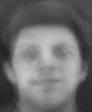

Image after NMF:


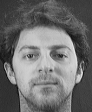

Image Before NMF:
-------------------------------Number of image: 161


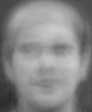

Image after NMF:


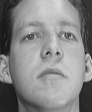

Image Before NMF:
-------------------------------Number of image: 162


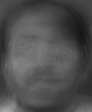

Image after NMF:


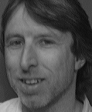

Image Before NMF:
-------------------------------Number of image: 163


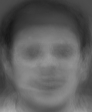

Image after NMF:


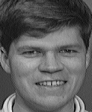

Image Before NMF:
-------------------------------Number of image: 164


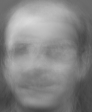

Image after NMF:


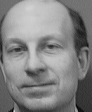

Image Before NMF:
-------------------------------Number of image: 165


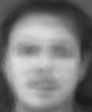

Image after NMF:


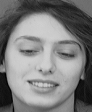

Image Before NMF:
-------------------------------Number of image: 166


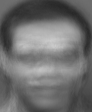

Image after NMF:


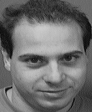

Image Before NMF:
-------------------------------Number of image: 167


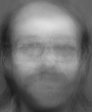

Image after NMF:


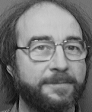

Image Before NMF:
-------------------------------Number of image: 168


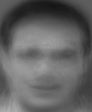

Image after NMF:


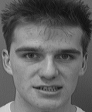

Image Before NMF:
-------------------------------Number of image: 169


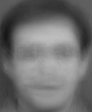

Image after NMF:


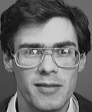

Image Before NMF:
-------------------------------Number of image: 170


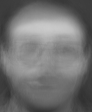

Image after NMF:


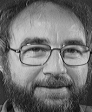

Image Before NMF:
-------------------------------Number of image: 171


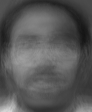

Image after NMF:


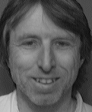

Image Before NMF:
-------------------------------Number of image: 172


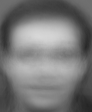

Image after NMF:


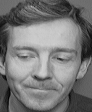

Image Before NMF:
-------------------------------Number of image: 173


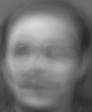

Image after NMF:


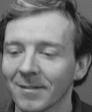

Image Before NMF:
-------------------------------Number of image: 174


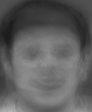

Image after NMF:


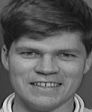

Image Before NMF:
-------------------------------Number of image: 175


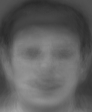

Image after NMF:


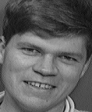

Image Before NMF:
-------------------------------Number of image: 176


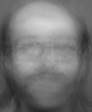

Image after NMF:


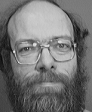

Image Before NMF:
-------------------------------Number of image: 177


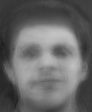

Image after NMF:


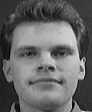

Image Before NMF:
-------------------------------Number of image: 178


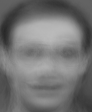

Image after NMF:


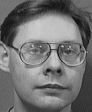

Image Before NMF:
-------------------------------Number of image: 179


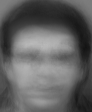

Image after NMF:


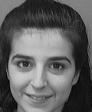

Image Before NMF:
-------------------------------Number of image: 180


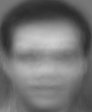

Image after NMF:


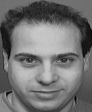

Image Before NMF:
-------------------------------Number of image: 181


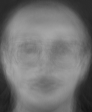

Image after NMF:


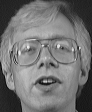

Image Before NMF:
-------------------------------Number of image: 182


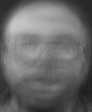

Image after NMF:


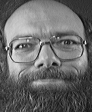

Image Before NMF:
-------------------------------Number of image: 183


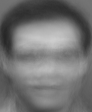

Image after NMF:


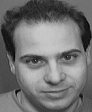

Image Before NMF:
-------------------------------Number of image: 184


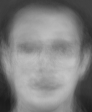

Image after NMF:


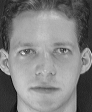

Image Before NMF:
-------------------------------Number of image: 185


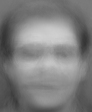

Image after NMF:


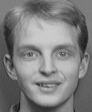

Image Before NMF:
-------------------------------Number of image: 186


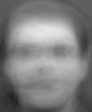

Image after NMF:


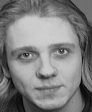

Image Before NMF:
-------------------------------Number of image: 187


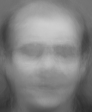

Image after NMF:


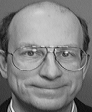

Image Before NMF:
-------------------------------Number of image: 188


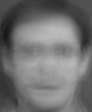

Image after NMF:


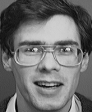

Image Before NMF:
-------------------------------Number of image: 189


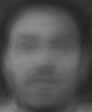

Image after NMF:


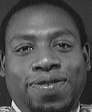

Image Before NMF:
-------------------------------Number of image: 190


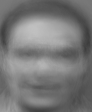

Image after NMF:


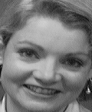

Image Before NMF:
-------------------------------Number of image: 191


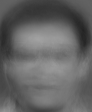

Image after NMF:


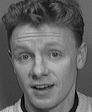

Image Before NMF:
-------------------------------Number of image: 192


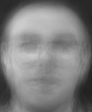

Image after NMF:


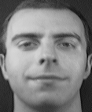

Image Before NMF:
-------------------------------Number of image: 193


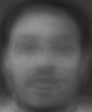

Image after NMF:


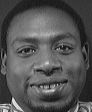

Image Before NMF:
-------------------------------Number of image: 194


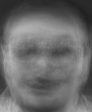

Image after NMF:


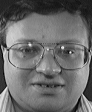

Image Before NMF:
-------------------------------Number of image: 195


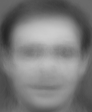

Image after NMF:


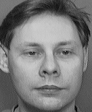

Image Before NMF:
-------------------------------Number of image: 196


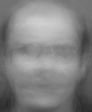

Image after NMF:


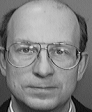

Image Before NMF:
-------------------------------Number of image: 197


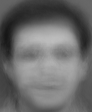

Image after NMF:


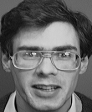

Image Before NMF:
-------------------------------Number of image: 198


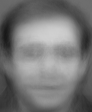

Image after NMF:


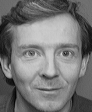

Image Before NMF:
-------------------------------Number of image: 199


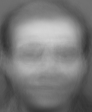

Image after NMF:


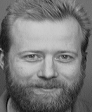

Image Before NMF:
-------------------------------Number of image: 200


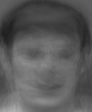

Image after NMF:


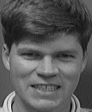

Image Before NMF:
-------------------------------Number of image: 201


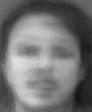

Image after NMF:


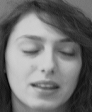

Image Before NMF:
-------------------------------Number of image: 202


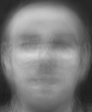

Image after NMF:


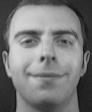

Image Before NMF:
-------------------------------Number of image: 203


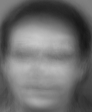

Image after NMF:


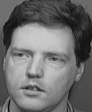

Image Before NMF:
-------------------------------Number of image: 204


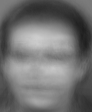

Image after NMF:


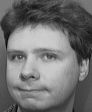

Image Before NMF:
-------------------------------Number of image: 205


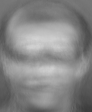

Image after NMF:


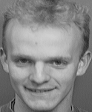

Image Before NMF:
-------------------------------Number of image: 206


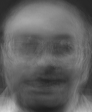

Image after NMF:


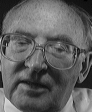

Image Before NMF:
-------------------------------Number of image: 207


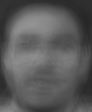

Image after NMF:


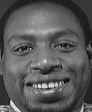

Image Before NMF:
-------------------------------Number of image: 208


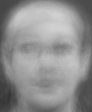

Image after NMF:


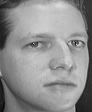

Image Before NMF:
-------------------------------Number of image: 209


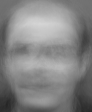

Image after NMF:


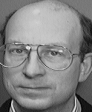

Image Before NMF:
-------------------------------Number of image: 210


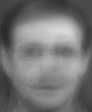

Image after NMF:


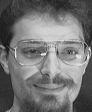

Image Before NMF:
-------------------------------Number of image: 211


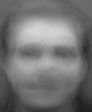

Image after NMF:


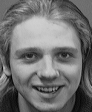

Image Before NMF:
-------------------------------Number of image: 212


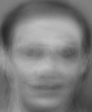

Image after NMF:


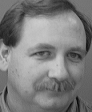

Image Before NMF:
-------------------------------Number of image: 213


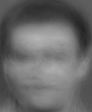

Image after NMF:


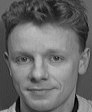

Image Before NMF:
-------------------------------Number of image: 214


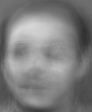

Image after NMF:


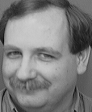

Image Before NMF:
-------------------------------Number of image: 215


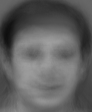

Image after NMF:


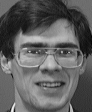

Image Before NMF:
-------------------------------Number of image: 216


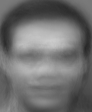

Image after NMF:


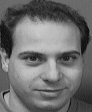

Image Before NMF:
-------------------------------Number of image: 217


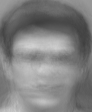

Image after NMF:


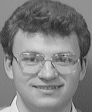

Image Before NMF:
-------------------------------Number of image: 218


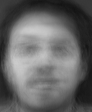

Image after NMF:


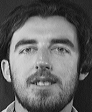

Image Before NMF:
-------------------------------Number of image: 219


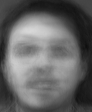

Image after NMF:


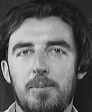

Image Before NMF:
-------------------------------Number of image: 220


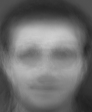

Image after NMF:


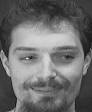

Image Before NMF:
-------------------------------Number of image: 221


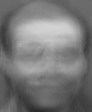

Image after NMF:


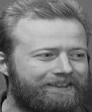

Image Before NMF:
-------------------------------Number of image: 222


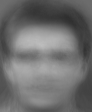

Image after NMF:


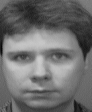

Image Before NMF:
-------------------------------Number of image: 223


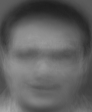

Image after NMF:


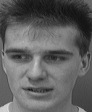

Image Before NMF:
-------------------------------Number of image: 224


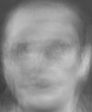

Image after NMF:


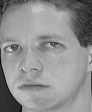

Image Before NMF:
-------------------------------Number of image: 225


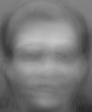

Image after NMF:


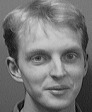

Image Before NMF:
-------------------------------Number of image: 226


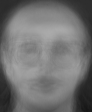

Image after NMF:


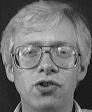

Image Before NMF:
-------------------------------Number of image: 227


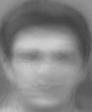

Image after NMF:


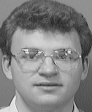

Image Before NMF:
-------------------------------Number of image: 228


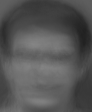

Image after NMF:


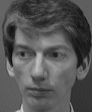

Image Before NMF:
-------------------------------Number of image: 229


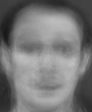

Image after NMF:


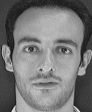

Image Before NMF:
-------------------------------Number of image: 230


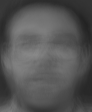

Image after NMF:


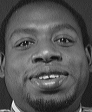

Image Before NMF:
-------------------------------Number of image: 231


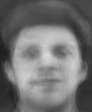

Image after NMF:


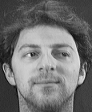

Image Before NMF:
-------------------------------Number of image: 232


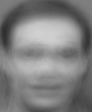

Image after NMF:


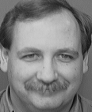

Image Before NMF:
-------------------------------Number of image: 233


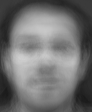

Image after NMF:


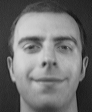

Image Before NMF:
-------------------------------Number of image: 234


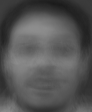

Image after NMF:


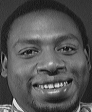

Image Before NMF:
-------------------------------Number of image: 235


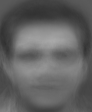

Image after NMF:


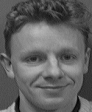

Image Before NMF:
-------------------------------Number of image: 236


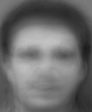

Image after NMF:


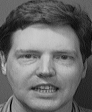

Image Before NMF:
-------------------------------Number of image: 237


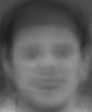

Image after NMF:


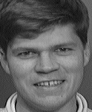

Image Before NMF:
-------------------------------Number of image: 238


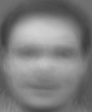

Image after NMF:


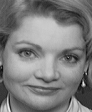

Image Before NMF:
-------------------------------Number of image: 239


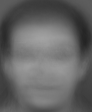

Image after NMF:


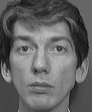

Image Before NMF:
-------------------------------Number of image: 240


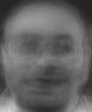

Image after NMF:


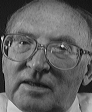

Image Before NMF:
-------------------------------Number of image: 241


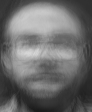

Image after NMF:


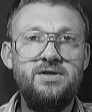

Image Before NMF:
-------------------------------Number of image: 242


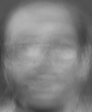

Image after NMF:


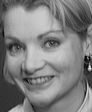

Image Before NMF:
-------------------------------Number of image: 243


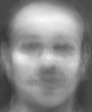

Image after NMF:


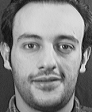

Image Before NMF:
-------------------------------Number of image: 244


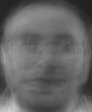

Image after NMF:


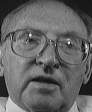

Image Before NMF:
-------------------------------Number of image: 245


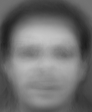

Image after NMF:


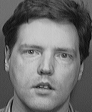

Image Before NMF:
-------------------------------Number of image: 246


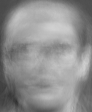

Image after NMF:


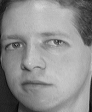

Image Before NMF:
-------------------------------Number of image: 247


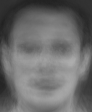

Image after NMF:


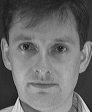

Image Before NMF:
-------------------------------Number of image: 248


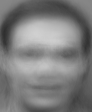

Image after NMF:


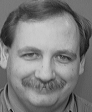

Image Before NMF:
-------------------------------Number of image: 249


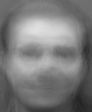

Image after NMF:


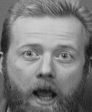

Image Before NMF:
-------------------------------Number of image: 250


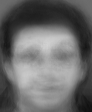

Image after NMF:


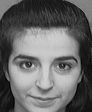

Image Before NMF:
-------------------------------Number of image: 251


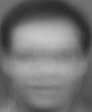

Image after NMF:


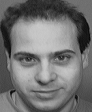

Image Before NMF:
-------------------------------Number of image: 252


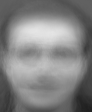

Image after NMF:


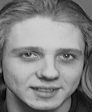

Image Before NMF:
-------------------------------Number of image: 253


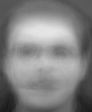

Image after NMF:


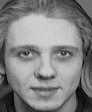

Image Before NMF:
-------------------------------Number of image: 254


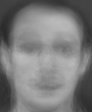

Image after NMF:


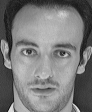

Image Before NMF:
-------------------------------Number of image: 255


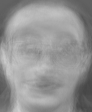

Image after NMF:


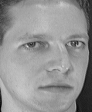

Image Before NMF:
-------------------------------Number of image: 256


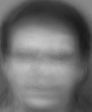

Image after NMF:


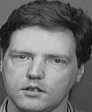

Image Before NMF:
-------------------------------Number of image: 257


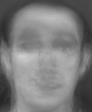

Image after NMF:


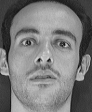

Image Before NMF:
-------------------------------Number of image: 258


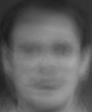

Image after NMF:


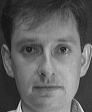

Image Before NMF:
-------------------------------Number of image: 259


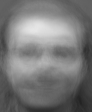

Image after NMF:


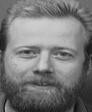

Image Before NMF:
-------------------------------Number of image: 260


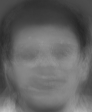

Image after NMF:


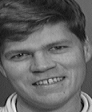

Image Before NMF:
-------------------------------Number of image: 261


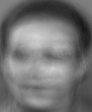

Image after NMF:


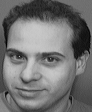

Image Before NMF:
-------------------------------Number of image: 262


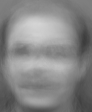

Image after NMF:


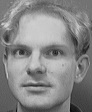

Image Before NMF:
-------------------------------Number of image: 263


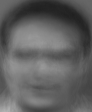

Image after NMF:


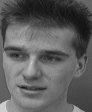

Image Before NMF:
-------------------------------Number of image: 264


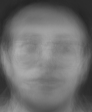

Image after NMF:


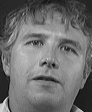

Image Before NMF:
-------------------------------Number of image: 265


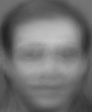

Image after NMF:


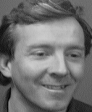

Image Before NMF:
-------------------------------Number of image: 266


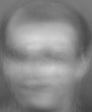

Image after NMF:


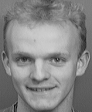

Image Before NMF:
-------------------------------Number of image: 267


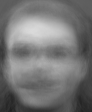

Image after NMF:


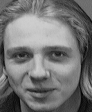

Image Before NMF:
-------------------------------Number of image: 268


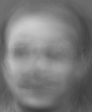

Image after NMF:


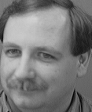

Image Before NMF:
-------------------------------Number of image: 269


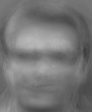

Image after NMF:


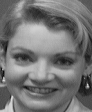

Image Before NMF:
-------------------------------Number of image: 270


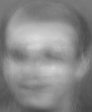

Image after NMF:


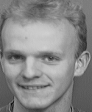

Image Before NMF:
-------------------------------Number of image: 271


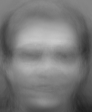

Image after NMF:


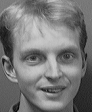

Image Before NMF:
-------------------------------Number of image: 272


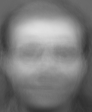

Image after NMF:


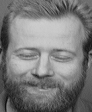

Image Before NMF:
-------------------------------Number of image: 273


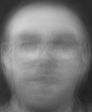

Image after NMF:


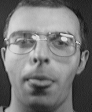

Image Before NMF:
-------------------------------Number of image: 274


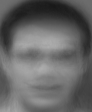

Image after NMF:


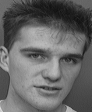

Image Before NMF:
-------------------------------Number of image: 275


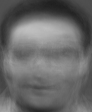

Image after NMF:


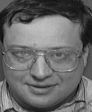

Image Before NMF:
-------------------------------Number of image: 276


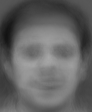

Image after NMF:


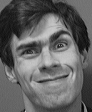

Image Before NMF:
-------------------------------Number of image: 277


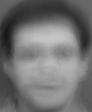

Image after NMF:


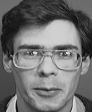

Image Before NMF:
-------------------------------Number of image: 278


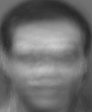

Image after NMF:


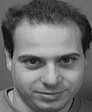

Image Before NMF:
-------------------------------Number of image: 279


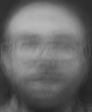

Image after NMF:


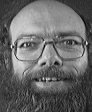

Image Before NMF:
-------------------------------Number of image: 280


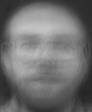

Image after NMF:


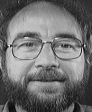

Image Before NMF:
-------------------------------Number of image: 281


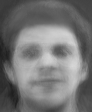

Image after NMF:


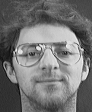

Image Before NMF:
-------------------------------Number of image: 282


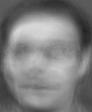

Image after NMF:


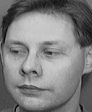

Image Before NMF:
-------------------------------Number of image: 283


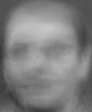

Image after NMF:


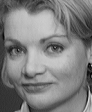

Image Before NMF:
-------------------------------Number of image: 284


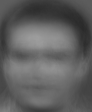

Image after NMF:


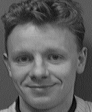

Image Before NMF:
-------------------------------Number of image: 285


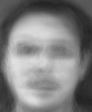

Image after NMF:


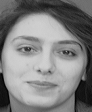

Image Before NMF:
-------------------------------Number of image: 286


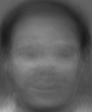

Image after NMF:


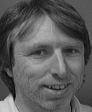

Image Before NMF:
-------------------------------Number of image: 287


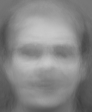

Image after NMF:


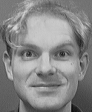

Image Before NMF:
-------------------------------Number of image: 288


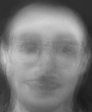

Image after NMF:


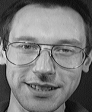

Image Before NMF:
-------------------------------Number of image: 289


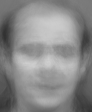

Image after NMF:


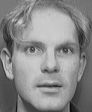

Image Before NMF:
-------------------------------Number of image: 290


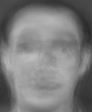

Image after NMF:


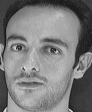

Image Before NMF:
-------------------------------Number of image: 291


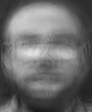

Image after NMF:


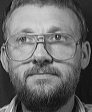

Image Before NMF:
-------------------------------Number of image: 292


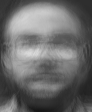

Image after NMF:


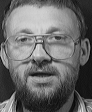

Image Before NMF:
-------------------------------Number of image: 293


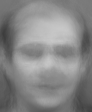

Image after NMF:


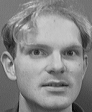

Image Before NMF:
-------------------------------Number of image: 294


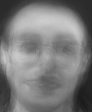

Image after NMF:


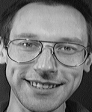

Image Before NMF:
-------------------------------Number of image: 295


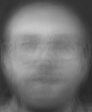

Image after NMF:


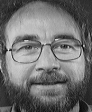

Image Before NMF:
-------------------------------Number of image: 296


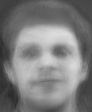

Image after NMF:


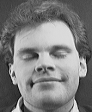

Image Before NMF:
-------------------------------Number of image: 297


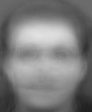

Image after NMF:


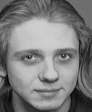

Image Before NMF:
-------------------------------Number of image: 298


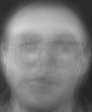

Image after NMF:


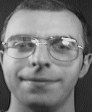

Image Before NMF:
-------------------------------Number of image: 299


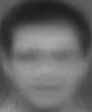

Image after NMF:


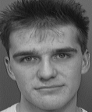

Image Before NMF:
-------------------------------Number of image: 300


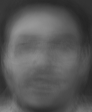

Image after NMF:


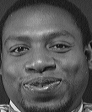

Image Before NMF:
-------------------------------Number of image: 301


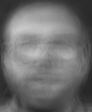

Image after NMF:


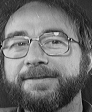

Image Before NMF:
-------------------------------Number of image: 302


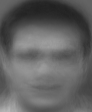

Image after NMF:


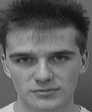

Image Before NMF:
-------------------------------Number of image: 303


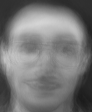

Image after NMF:


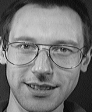

Image Before NMF:
-------------------------------Number of image: 304


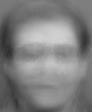

Image after NMF:


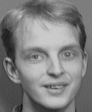

Image Before NMF:
-------------------------------Number of image: 305


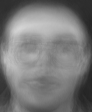

Image after NMF:


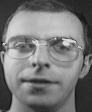

Image Before NMF:
-------------------------------Number of image: 306


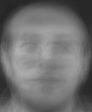

Image after NMF:


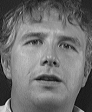

Image Before NMF:
-------------------------------Number of image: 307


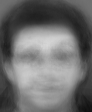

Image after NMF:


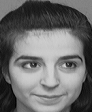

Image Before NMF:
-------------------------------Number of image: 308


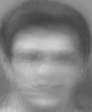

Image after NMF:


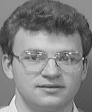

Image Before NMF:
-------------------------------Number of image: 309


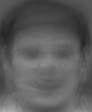

Image after NMF:


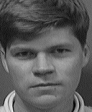

Image Before NMF:
-------------------------------Number of image: 310


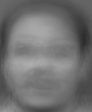

Image after NMF:


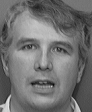

Image Before NMF:
-------------------------------Number of image: 311


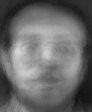

Image after NMF:


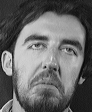

Image Before NMF:
-------------------------------Number of image: 312


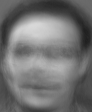

Image after NMF:


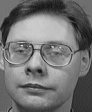

Image Before NMF:
-------------------------------Number of image: 313


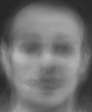

Image after NMF:


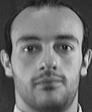

Image Before NMF:
-------------------------------Number of image: 314


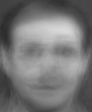

Image after NMF:


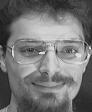

Image Before NMF:
-------------------------------Number of image: 315


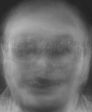

Image after NMF:


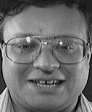

Image Before NMF:
-------------------------------Number of image: 316


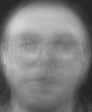

Image after NMF:


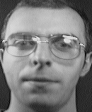

Image Before NMF:
-------------------------------Number of image: 317


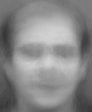

Image after NMF:


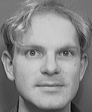

Image Before NMF:
-------------------------------Number of image: 318


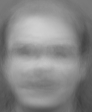

Image after NMF:


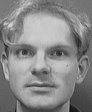

Image Before NMF:
-------------------------------Number of image: 319


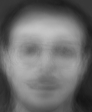

Image after NMF:


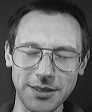

Image Before NMF:
-------------------------------Number of image: 320


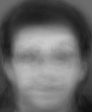

Image after NMF:


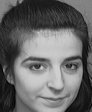

Image Before NMF:
-------------------------------Number of image: 321


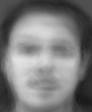

Image after NMF:


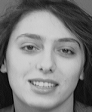

Image Before NMF:
-------------------------------Number of image: 322


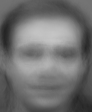

Image after NMF:


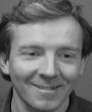

Image Before NMF:
-------------------------------Number of image: 323


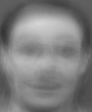

Image after NMF:


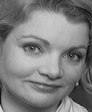

Image Before NMF:
-------------------------------Number of image: 324


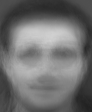

Image after NMF:


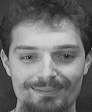

Image Before NMF:
-------------------------------Number of image: 325


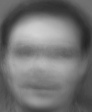

Image after NMF:


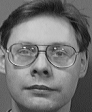

Image Before NMF:
-------------------------------Number of image: 326


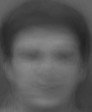

Image after NMF:


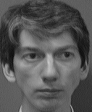

Image Before NMF:
-------------------------------Number of image: 327


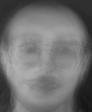

Image after NMF:


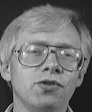

Image Before NMF:
-------------------------------Number of image: 328


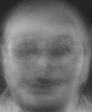

Image after NMF:


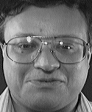

Image Before NMF:
-------------------------------Number of image: 329


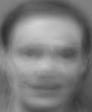

Image after NMF:


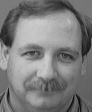

Image Before NMF:
-------------------------------Number of image: 330


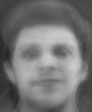

Image after NMF:


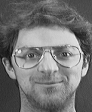

Image Before NMF:
-------------------------------Number of image: 331


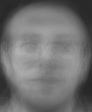

Image after NMF:


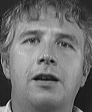

Image Before NMF:
-------------------------------Number of image: 332


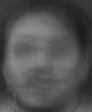

Image after NMF:


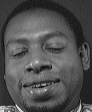

Image Before NMF:
-------------------------------Number of image: 333


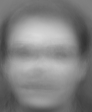

Image after NMF:


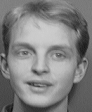

Image Before NMF:
-------------------------------Number of image: 334


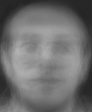

Image after NMF:


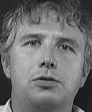

Image Before NMF:
-------------------------------Number of image: 335


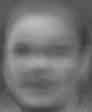

Image after NMF:


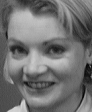

Image Before NMF:
-------------------------------Number of image: 336


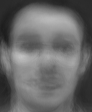

Image after NMF:


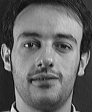

Image Before NMF:
-------------------------------Number of image: 337


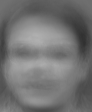

Image after NMF:


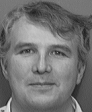

Image Before NMF:
-------------------------------Number of image: 338


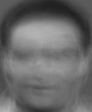

Image after NMF:


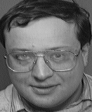

Image Before NMF:
-------------------------------Number of image: 339


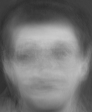

Image after NMF:


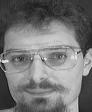

Image Before NMF:
-------------------------------Number of image: 340


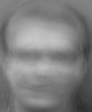

Image after NMF:


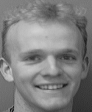

Image Before NMF:
-------------------------------Number of image: 341


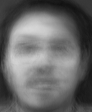

Image after NMF:


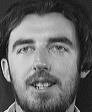

Image Before NMF:
-------------------------------Number of image: 342


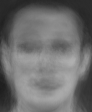

Image after NMF:


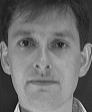

Image Before NMF:
-------------------------------Number of image: 343


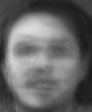

Image after NMF:


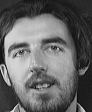

Image Before NMF:
-------------------------------Number of image: 344


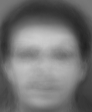

Image after NMF:


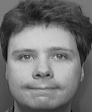

Image Before NMF:
-------------------------------Number of image: 345


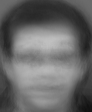

Image after NMF:


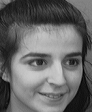

Image Before NMF:
-------------------------------Number of image: 346


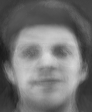

Image after NMF:


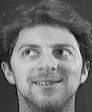

Image Before NMF:
-------------------------------Number of image: 347


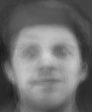

Image after NMF:


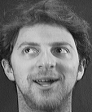

Image Before NMF:
-------------------------------Number of image: 348


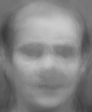

Image after NMF:


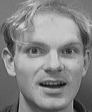

Image Before NMF:
-------------------------------Number of image: 349


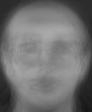

Image after NMF:


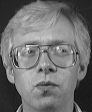

Image Before NMF:
-------------------------------Number of image: 350


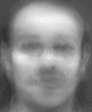

Image after NMF:


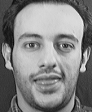

Image Before NMF:


In [41]:
compareAndTest(m,w,h, 1)

In [ ]:
x_new=np.matmul(w,h)
x_new=np.ceil(x_new*1)
x_new=np.transpose(x_new)

print("Original Image Set Variance: "+str(variance(np.ceil(np.transpose(m)*1))))
print("NMF Generated Image Set Variance: "+str(variance(x_new)))

In [ ]:
w.shape

In [ ]:
kmeans=compareAndTestWithKNN(m,w,h, 1, 3)

In [ ]:
scatterPlot(kmeans,w)